In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [5]:
import sys
import locale
from pathlib import Path
import subprocess
from typing import List
import pandas as pd
import numpy as np
import numpy.random as rn
import matplotlib.pyplot as plt
import seaborn.objects as so
import urllib.request
import zipfile
import dtreeviz

In [3]:
import xgboost as xgb
from feature_engine import encoding, imputation
from sklearn import base, pipeline
from sklearn import model_selection
from sklearn import tree
from sklearn import dummy
from sklearn import preprocessing
from yellowbrick.model_selection import validation_curve

In [6]:
sys.path.append("../..")

In [60]:
import src.data.Utils as Utils
import src.data.KagTransformer as KagTransformer
import src.data.ThresholdXGBClassifier as ThresholdXGBClassifier

In [8]:
locale.setlocale(locale.LC_ALL, "es_ES.UTF-8")
pd.set_option("display.max_columns", None)
pd.set_option("display.float_format", "{:,.1f}".format)

### Set Variables and Paths

*Variables*

In [9]:
url: str = (
    "https://github.com/mattharrison/datasets/raw/master/data/" "kaggle-survey-2018.zip"
)
folder_name: str = "kaggle-survey-2018.zip"
member_name: str = "multipleChoiceResponses.csv"

*Paths*

In [10]:
HOME: Path = Path.cwd().parents
data_folder: str = HOME[1] / f"data/raw/{folder_name}"

### Helper Funcs

In [11]:
def calc_gini(
    df: pd.DataFrame,
    val_col: str,
    label_col: str,
    pos_val: str,
    split_point: float,
    debug: bool = False,
) -> float:
    """
    This function calculates the Gini impurity of a dataset. Gini impurity
    is a measure of the probability of a random sample being classified incorrectly
    when a feature is used to split the data.
    The lower the impurity, the better the split.

    Args:
        df: pd.DataFrame
            The input DataFrame.
        val_col: str
            The name of the column containing the values to be used for splitting.
        label_col: str
            The name of the target variable.
        pos_val: str, int
            The value of the target variable that represents the positive class.
        split_point: float
            The threshold used to split the data.
        debug: bool, optional, default `False`
            If `True`, prints the calculated Gini impurities and the final
            weighted  average.

    Returns:
        float: The weighted average of Gini impurity for the positive and negative subsets.
    """
    ge_split = df[val_col] >= split_point
    eq_pos = df[label_col] == pos_val
    tp = df[ge_split & eq_pos].shape[0]
    fp = df[ge_split & ~eq_pos].shape[0]
    tn = df[~ge_split & ~eq_pos].shape[0]
    fn = df[~ge_split & eq_pos].shape[0]
    pos_size = tp + fp
    neg_size = tn + fn
    total_size = len(df)
    if pos_size == 0:
        gini_pos = 0
    else:
        gini_pos = 1 - (tp / pos_size) ** 2 - (fp / pos_size) ** 2
    if neg_size == 0:
        gini_neg = 0
    else:
        gini_neg = 1 - (tn / neg_size) ** 2 - (fn / neg_size) ** 2
    weighted_avg = gini_pos * (pos_size / total_size) + gini_neg * (
        neg_size / total_size
    )
    if debug:
        print(f"{gini_pos=:.3} {gini_neg=:.3} {weighted_avg=:.3}")
    return weighted_avg

In [64]:
def get_tpr_fpr(probs: np.array, y_truth) -> tuple:
    """
    Calculate true positive rate (TPR) and false positive rate (FPR) given
    predicted probabilities and ground truth labels.

    Args:
        ------
        probs: np.array
            Predicted probabilities of positive class.
        y_truth: np.array
            Ground truth labels.
        
    Returns:
        -------
        tuple: (tpr, fpr)
    """
    tp = (probs == 1) & (y_truth == 1)
    tn = (probs < 1) & (y_truth == 0)
    fp = (probs == 1) & (y_truth == 0)
    fn = (probs < 1) & (y_truth == 1)
    tpr = tp.sum() / (tp.sum() + fn.sum())
    fpr = fp.sum() / (fp.sum() + tn.sum())
    return tpr, fpr

### Classes

#### Datasets

In [12]:
raw = Utils.Utils.extract_zip(url, data_folder, member_name)

File /Users/everreyesruiz/Documents/SandBox/xgboostProject/data/raw/kaggle-survey-2018.zip already exists. Skipping download.
Extracting multipleChoiceResponses.csv from /Users/everreyesruiz/Documents/SandBox/xgboostProject/data/raw/kaggle-survey-2018.zip...
Reading multipleChoiceResponses.csv into a DataFrame...
Returning DataFrame with 23859 rows and 395 columns


#### Create a pipeline

In [13]:
kag_pl = pipeline.Pipeline(
    [
        ("tweak", KagTransformer.TweakKagTransformer()),
        (
            "cat",
            encoding.OneHotEncoder(
                top_categories=5, drop_last=True, variables=["Q1", "Q3", "major"]
            ),
        ),
        (
            "num_impute",
            imputation.MeanMedianImputer(
                imputation_method="median", variables=["education", "years_exp"]
            ),
        ),
    ]
)

In [14]:
kag_X, kag_y = Utils.Utils.get_rawx_y(raw, "Q6")

In [15]:
kag_X_train, kag_X_test, kag_y_train, kag_y_test = model_selection.train_test_split(
    kag_X, kag_y, test_size=0.3, random_state=42, stratify=kag_y
)

In [16]:
X_train = kag_pl.fit_transform(kag_X_train, kag_y_train)

In [17]:
x_test = kag_pl.transform(kag_X_test)

In [18]:
kag_y_train

587      Software Engineer
3065        Data Scientist
8435        Data Scientist
3110        Data Scientist
16372    Software Engineer
               ...        
16608    Software Engineer
7325     Software Engineer
21810       Data Scientist
4917        Data Scientist
639         Data Scientist
Name: Q6, Length: 2110, dtype: object

## EDA

In [19]:
(
    X_train.assign(data_scientist=kag_y_train == "Data Scientist")
    .corr(method="spearman")
    .style.background_gradient(cmap="RdBu", vmax=1, vmin=-1)
    .set_sticky(axis="index")
)

,age,education,years_exp,compensation,python,r,sql,Q1_Male,Q1_Female,Q1_Prefer not to say,Q1_Prefer to self-describe,Q3_United States of America,Q3_India,Q3_China,major_cs,major_other,major_eng,major_stat,data_scientist
age,1.000000,0.345717,0.644863,0.451349,0.046651,0.127667,0.134325,0.014277,-0.033693,0.051232,0.041474,0.371123,-0.363626,-0.023384,-0.223529,0.201910,0.006262,0.073864,0.075440
education,0.345717,1.000000,0.098849,0.241393,0.060259,0.151244,0.066620,-0.079534,0.064777,0.060984,0.002701,0.272790,-0.273408,-0.006441,-0.216724,0.164771,-0.001043,0.121294,0.266717
years_exp,0.644863,0.098849,1.000000,0.255164,-0.055408,0.012090,0.050181,0.083624,-0.097564,0.034470,0.016784,0.117912,-0.136666,0.029630,-0.046551,0.018267,0.004264,0.042917,-0.145461
compensation,0.451349,0.241393,0.255164,1.000000,0.165070,0.171485,0.201336,0.000967,0.002912,-0.035554,0.049881,0.616759,-0.556154,-0.123281,-0.225934,0.241580,-0.060256,0.109100,0.174434
python,0.046651,0.060259,-0.055408,0.165070,1.000000,0.183665,0.287957,0.039944,-0.039207,-0.006729,-0.000553,0.052339,-0.043101,-0.017642,-0.095136,0.093887,0.008640,0.013474,0.121741
r,0.127667,0.151244,0.012090,0.171485,0.183665,1.000000,0.276862,-0.066982,0.068157,0.004831,-0.004454,0.178682,-0.105625,-0.133029,-0.205538,0.139994,-0.022082,0.162942,0.329124
sql,0.134325,0.066620,0.050181,0.201336,0.287957,0.276862,1.000000,-0.026692,0.032639,-0.010814,-0.018499,0.166587,-0.107382,-0.108406,-0.130081,0.109862,-0.012964,0.073906,0.117941
Q1_Male,0.014277,-0.079534,0.083624,0.000967,0.039944,-0.066982,-0.026692,1.000000,-0.957007,-0.222963,-0.094664,-0.144665,0.116961,0.052566,0.062605,-0.071139,0.028492,-0.039544,-0.091126
Q1_Female,-0.033693,0.064777,-0.097564,0.002912,-0.039207,0.068157,0.032639,-0.957007,1.000000,-0.045225,-0.019201,0.131051,-0.105490,-0.048434,-0.049753,0.064054,-0.034760,0.036779,0.086614
Q1_Prefer not to say,0.051232,0.060984,0.034470,-0.035554,-0.006729,0.004831,-0.010814,-0.222963,-0.045225,1.000000,-0.004473,0.046366,-0.038587,-0.014918,-0.045908,0.010336,0.029149,0.021052,0.018540


*BarPlot*

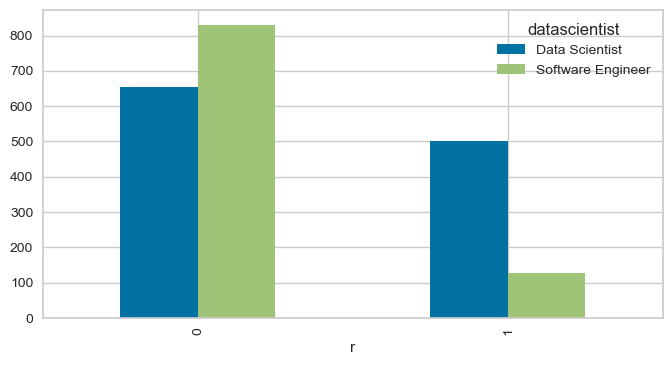

In [20]:
# r = 0.32 positive correlation
fig, ax = plt.subplots(figsize=(8, 4))
(
    X_train.assign(datascientist=kag_y_train)
    .groupby("r")
    .datascientist.value_counts()
    .unstack()
    .plot.bar(ax=ax)
)
plt.show()

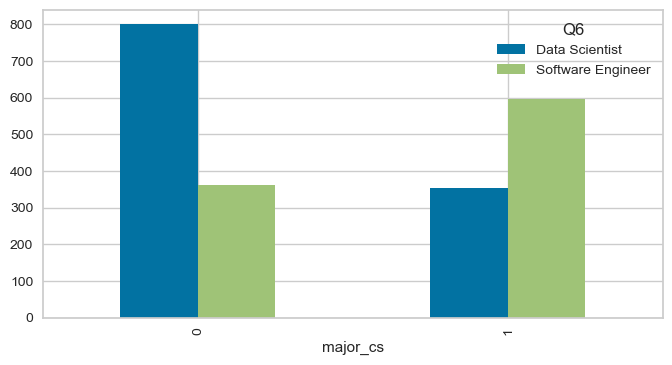

In [21]:
# Major most negative correlation -0.31
fig, ax = plt.subplots(figsize=(8, 4))
(pd.crosstab(index=X_train["major_cs"], columns=kag_y).plot.bar(ax=ax))
plt.show()

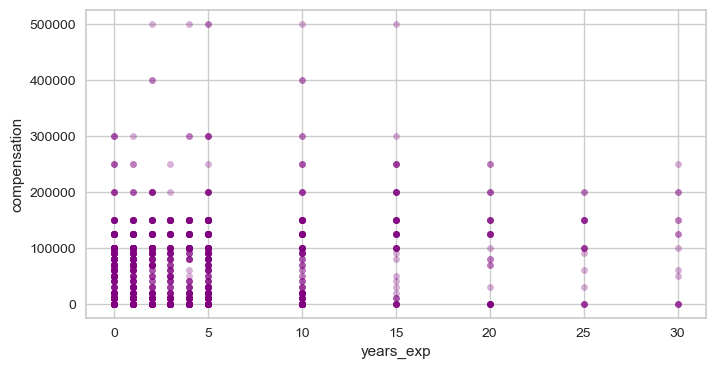

In [22]:
fig, ax = plt.subplots(figsize=(8, 4))
(X_train.plot.scatter(x="years_exp", y="compensation", alpha=0.3, ax=ax, c="purple"))
plt.show()

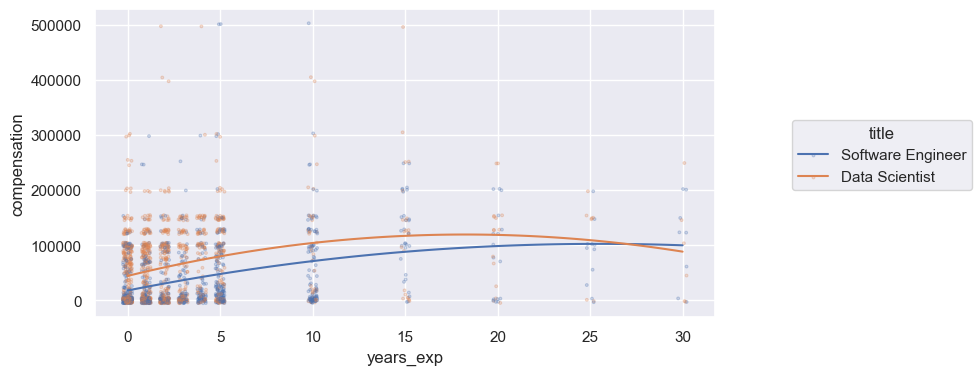

In [23]:
# Fix that binned data
fig = plt.figure(figsize=(8, 4))
(
    so.Plot(
        X_train.assign(title=kag_y_train),
        x="years_exp",
        y="compensation",
        color="title",
    )
    .add(so.Dots(alpha=0.3, pointsize=2), so.Jitter(x=0.5, y=10_000))
    .add(so.Line(), so.PolyFit())
    .on(fig)  # not required unless saving to image
    .plot()
)
plt.show()

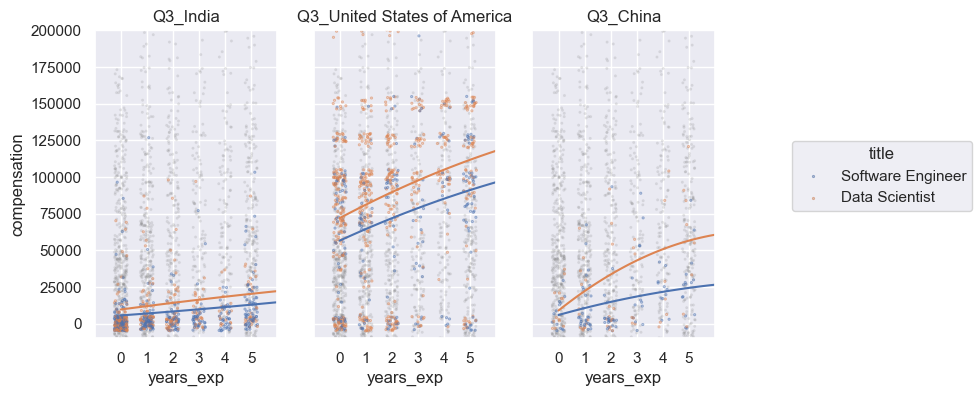

In [24]:
fig = plt.figure(figsize=(8, 4))
(
    so.Plot(
        X_train
        #        .query('compensation < 200_000 and years_exp < 16')
        .assign(
            title=kag_y_train,
            country=(
                X_train.loc[:, "Q3_United States of America":"Q3_China"].idxmax(
                    axis="columns"
                )
            ),
        ),
        x="years_exp",
        y="compensation",
        color="title",
    )
    .facet("country")
    .add(
        so.Dots(alpha=0.01, pointsize=2, color="grey"),
        so.Jitter(x=0.5, y=10_0000),
        col=None,
    )
    .add(so.Dots(alpha=0.5, pointsize=1.5), so.Jitter(x=0.5, y=10_000))
    .add(so.Line(pointsize=1), so.PolyFit(order=2))
    .scale(x=so.Continuous().tick(at=[0, 1, 2, 3, 4, 5]))
    .limit(y=(-10_000, 200_000), x=(-1, 6))  # Zoom in with this not .query(above)
    .on(fig)
    .plot()
)
plt.show()

# ScikitLearn and stump

In [25]:
stump_dt = tree.DecisionTreeClassifier(max_depth=1)

In [26]:
X_train = kag_pl.fit_transform(kag_X_train)

In [27]:
stump_dt.fit(X_train, kag_y_train)

DecisionTreeClassifier(max_depth=1)

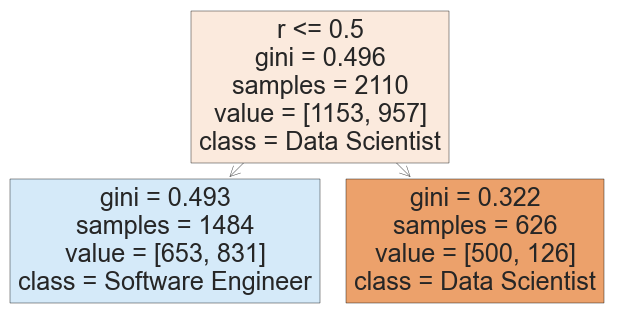

In [28]:
# lets graph it
fig, ax = plt.subplots(figsize=(8, 4))
features = list(c for c in X_train.columns)
tree.plot_tree(
    stump_dt, feature_names=features, filled=True, class_names=stump_dt.classes_, ax=ax
)
plt.show()

In [29]:
X_test = kag_pl.transform(kag_X_test)

In [30]:
stump_dt.score(X_test, kag_y_test)

0.6243093922651933

In [31]:
# DummyClassifier
dummy_model = dummy.DummyClassifier()

In [32]:
dummy_model.fit(X_train, kag_y_train)

DummyClassifier()

In [33]:
dummy_model.score(X_test, kag_y_test)

0.5458563535911602

# XGBOOST MODEL

In [34]:
kag_y_train == "Software Engineer"

587       True
3065     False
8435     False
3110     False
16372     True
         ...  
16608     True
7325      True
21810    False
4917     False
639      False
Name: Q6, Length: 2110, dtype: bool

In [35]:
label_encoder = preprocessing.LabelEncoder()

In [36]:
y_train = label_encoder.fit_transform(kag_y_train)

In [37]:
y_test = label_encoder.transform(kag_y_test)

In [38]:
y_test[:5]

array([1, 0, 0, 1, 1])

In [39]:
label_encoder.classes_

array(['Data Scientist', 'Software Engineer'], dtype=object)

In [40]:
label_encoder.inverse_transform([0, 1])

array(['Data Scientist', 'Software Engineer'], dtype=object)

In [41]:
kag_stump = xgb.XGBClassifier(n_estimators=1, max_depth=1)

In [42]:
kag_stump.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=1, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=1, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [43]:
kag_stump.score(X_test, y_test)

0.6243093922651933

# Gini Coefficient

In [44]:
pos_center = 12
pos_count = 100
neg_center = 7
neg_count = 1000

In [45]:
rs = rn.RandomState(rn.MT19937(rn.SeedSequence(42)))

In [46]:
gini = pd.DataFrame(
    {
        "value": np.append(
            (pos_center) + rs.randn(pos_count), (neg_center) + rs.randn(neg_count)
        ),
        "label": ["pos"] * pos_count + ["neg"] * neg_count,
    }
)

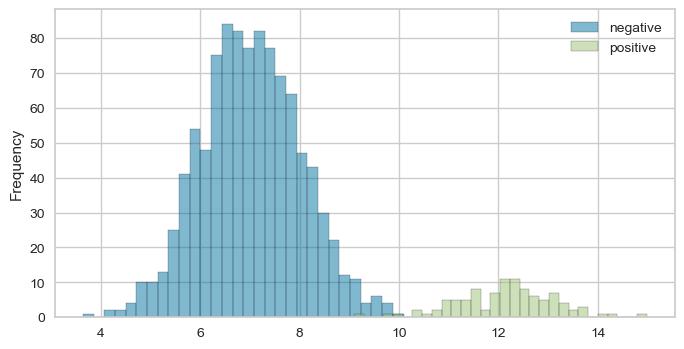

In [47]:
fig, ax = plt.subplots(figsize=(8, 4))
_ = gini.groupby("label")[["value"]].plot.hist(
    bins=30, alpha=0.5, ax=ax, edgecolor="black"
)
ax.legend(["negative", "positive"])
plt.show()

In [48]:
calc_gini(
    gini,
    val_col="value",
    label_col="label",
    pos_val="pos",
    split_point=9.24,
    debug=True,
)

gini_pos=0.217 gini_neg=0.00202 weighted_avg=0.0241


0.024117224644432264

In [49]:
values = np.arange(5, 15, 0.1)
ginis: List = []
for v in values:
    ginis.append(
        calc_gini(
            gini, val_col="value", label_col="label", pos_val="pos", split_point=v
        )
    )

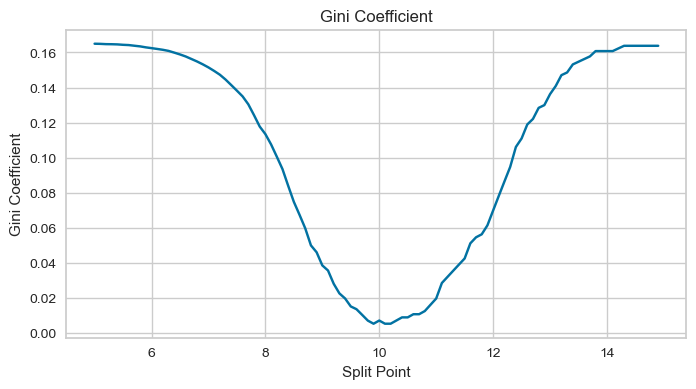

In [50]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(values, ginis)
ax.set_title("Gini Coefficient")
ax.set_ylabel("Gini Coefficient")
ax.set_xlabel("Split Point")
plt.show()

In [51]:
# Limiting Max depth
xg_stump = xgb.XGBClassifier(n_estimators=1, max_depth=1)
xg_stump.fit(gini[["value"]], (gini.label == "poss"))

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=1, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=1, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

# Visualization tools

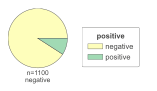

In [52]:
viz = dtreeviz.model(
    xg_stump,
    X_train=gini[["value"]],
    y_train=gini.label == "pos",
    target_name="positive",
    feature_names=["value"],
    class_names=["negative", "positive"],
    tree_index=0,
)
viz.view()

## YELLOWBRICK

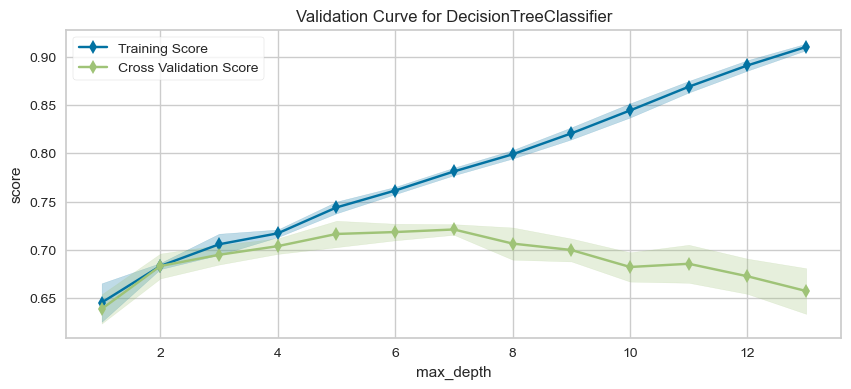

In [53]:
fig, ax = plt.subplots(figsize=(10, 4))
viz = validation_curve(
    tree.DecisionTreeClassifier(),
    X=pd.concat([X_train, X_test]),
    y=pd.concat([kag_y_train, kag_y_test]),
    param_name="max_depth",
    param_range=range(1, 14),
    scoring="accuracy",
    cv=5,
    ax=ax,
    n_jobs=6,
)
plt.show()

## Thresholds

In [54]:
xgb_def = xgb.XGBClassifier()

In [55]:
xgb_def.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [57]:
xgb_def.predict_proba(X_test.iloc[[0]])

array([[0.14253652, 0.8574635 ]], dtype=float32)

In [58]:
xgb_def.predict(X_test.iloc[[0]])

array([1])

In [61]:
# Set treshold to .9
xgb90 = ThresholdXGBClassifier.ThresholdXGBClassifier(treshold=0.9, verbosity=0)

In [62]:
xgb90.fit(X_train, y_train)

ThresholdXGBClassifier(base_score=None, booster=None, callbacks=None,
                       colsample_bylevel=None, colsample_bynode=None,
                       colsample_bytree=None, early_stopping_rounds=None,
                       enable_categorical=False, eval_metric=None,
                       feature_types=None, gamma=None, gpu_id=None,
                       grow_policy=None, importance_type=None,
                       interaction_constraints=None, learning_rate=None,
                       max_bin=None, max_cat_threshold=None,
                       max_cat_to_onehot=None, max_delta_step=None,
                       max_depth=None, max_leaves=None, min_child_weight=None,
                       missing=nan, monotone_constraints=None, n_estimators=100,
                       n_jobs=None, num_parallel_tree=None,
                       objective='binary:logistic', predictor=None, ...)

In [63]:
xgb90.predict(X_test.iloc[[0]])

array([1])